In [1]:
from heat_solver import HeatForwardSolver1D
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from pprint import pprint
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


In [2]:
# parameters
alpha = .5
delta_x = 1.0
delta_t = 0.0625
domain_length = 100
max_iter = 600
t_end = max_iter * delta_t
number_pts =  100
delta_x = domain_length / number_pts

def boundaries_example(u: np.ndarray, k: int, delta_t: float):
    '''
    Dirichlet BC：
    u(0, t) = 0, u(L, t) = 0
    '''
    u[0, k] = 0.0              # left border
    u[-1, k] = 0.0             # right border

solver = HeatForwardSolver1D(
    alpha=alpha,
    delta_x=delta_x,
    domain_length=domain_length,
    delta_t=delta_t,
    max_iter=max_iter
)

x = np.linspace(0, domain_length, number_pts)
t = np.linspace(0, t_end, max_iter)

# initial condition
u0 = np.exp(-100*(x-0.5)**2).astype(np.float32) + np.sin(1/5*x).astype(np.float32)
solver.set_initial(u0)
solver.set_boundaries(boundaries_example)

solver.solve()
u_solution = solver.get_solution()


Running solver: 100%|██████████| 599/599 [00:00<00:00, 186628.15it/s]

Time: 0.00763 seconds


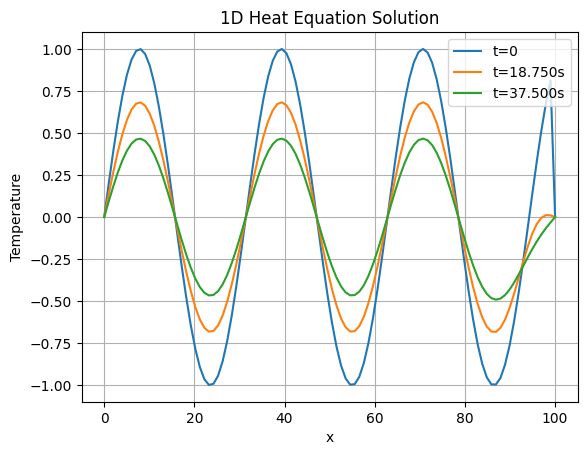

In [3]:
#Draw the temperature distribution at the initial, final, and intermediate moments
plt.plot(x, u_solution[:,0], label='t=0')
plt.plot(x, u_solution[:,max_iter//2], label=f't={delta_t*(max_iter//2):.3f}s')
plt.plot(x, u_solution[:,-1], label=f't={delta_t*max_iter:.3f}s')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('1D Heat Equation Solution')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def plot3D(x, t, u_solution):
    # 1) Ensure x, t, u_solution are NumPy arrays
    if hasattr(x, "detach"):
        x = x.detach().cpu().numpy()
    if hasattr(t, "detach"):
        t = t.detach().cpu().numpy()
    # u_solution is already a NumPy array of shape (num_points, max_iter)

    # 2) Use x and t (1D vectors) to create a meshgrid
    #    'ij' indexing yields arrays shaped (len(x), len(t))
    X, T = np.meshgrid(x, t, indexing='ij')

    # 3) Verify that the shapes of X, u_solution, and T all match
    assert X.shape == u_solution.shape == T.shape, (
        f"Shapes must match: X {X.shape}, u {u_solution.shape}, T {T.shape}"
    )

    # 4) Plot a contour map
    fig, ax = plt.subplots(figsize=(6, 5))
    contour = ax.contourf(T, X, u_solution, levels=20, cmap="rainbow")
    fig.colorbar(contour, ax=ax)
    ax.set_title('u(x, t) – Contour Plot')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()

    # 5) Plot a 3D surface
    fig = plt.figure(figsize=(7, 5))
    ax3 = fig.add_subplot(111, projection='3d')
    ax3.plot_surface(T, X, u_solution, cmap="rainbow", edgecolor='none')
    ax3.set_title('u(x, t) – Surface Plot')
    ax3.set_xlabel('t')
    ax3.set_ylabel('x')
    ax3.set_zlabel('u')
    plt.show()


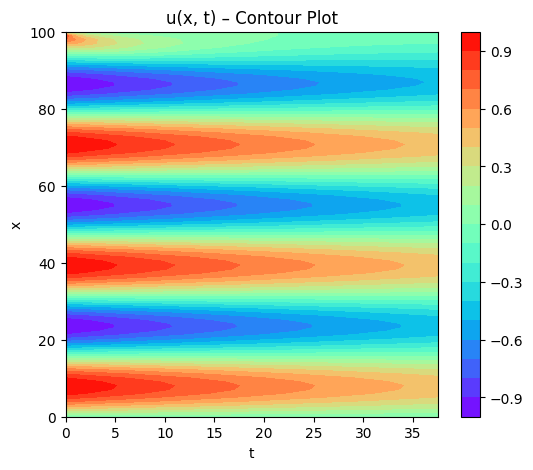

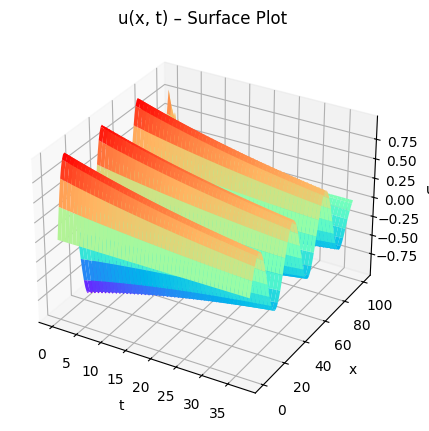

In [5]:
plot3D(x,t,u_solution)

# Tuning Parameters

In [6]:
steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

# Nerual network

In [7]:
class FCN(nn.Module):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f=f_t-0.5*f_xx
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss   

# Turn results from numpy array to torch tensor

In [8]:
# 1D tensors for x and t
# x: numpy array of shape (number_pts,)
# t: numpy array of shape (max_iter,)
x_tensor = torch.from_numpy(x).float().to(device)       # shape: (number_pts,)
t_tensor = torch.from_numpy(t).float().to(device)       # shape: (max_iter,)

# If you need column vectors:
x_col = x_tensor.unsqueeze(1)   # shape: (number_pts, 1)
t_col = t_tensor.unsqueeze(1)   # shape: (max_iter, 1)

# 2D tensor for the solution u(x,t)
# u_solution: numpy array of shape (number_pts, max_iter)
u_tensor = torch.from_numpy(u_solution).float().to(device)  # shape: (number_pts, max_iter)

# Create 2D meshgrid tensors (same shape as u_tensor)
# PyTorch 1.10+ supports explicit indexing; for older versions omit indexing argument
X_grid, T_grid = torch.meshgrid(x_tensor, t_tensor, indexing='ij')
# shapes: both (number_pts, max_iter)

# Now:
# - x_tensor, t_tensor are 1D tensors
# - x_col, t_col are 2D column vectors
# - u_tensor, X_grid, T_grid are 2D tensors suitable for PyTorch models/plots

print(x_tensor.shape)   # → torch.Size([100])
print(t_tensor.shape)   # → torch.Size([600])
print(u_tensor.shape)   # → torch.Size([100, 600])
print(X_grid.shape, T_grid.shape)  # → torch.Size([100, 600]) torch.Size([100, 600])

torch.Size([100])
torch.Size([600])
torch.Size([100, 600])
torch.Size([100, 600]) torch.Size([100, 600])


# Training sets

In [12]:
# x_tensor: shape (number_pts,), 1D spatial coordinate tensor
# t_tensor: shape (max_iter,), 1D time coordinate tensor
# u_tensor: shape (number_pts, max_iter), numerical solution tensor
# device: torch.device
# domain_length, t_end: maximum x and maximum t values respectively

# 1) Left boundary x=0, for all t
X_bc_left = torch.zeros_like(t_tensor)                # shape: (max_iter,)
T_bc_left = t_tensor.clone()                          # shape: (max_iter,)
U_bc_left = u_tensor[0, :].clone()                    # shape: (max_iter,)

# 2) Right boundary x=domain_length, for all t
X_bc_right = torch.full_like(t_tensor, domain_length) # shape: (max_iter,)
T_bc_right = t_tensor.clone()                         # shape: (max_iter,)
U_bc_right = u_tensor[-1, :].clone()                  # shape: (max_iter,)

# 3) Initial condition t=0, for all x
X_ic = x_tensor.clone()                               # shape: (number_pts,)
T_ic = torch.zeros_like(x_tensor)                     # shape: (number_pts,)
U_ic = u_tensor[:, 0].clone()                         # shape: (number_pts,)

# 4) Combine all boundary and initial condition points
X_train_nu = torch.cat([X_bc_left, X_bc_right, X_ic], dim=0).unsqueeze(1).to(device)  # (2*max_iter+number_pts, 1)
T_train_nu = torch.cat([T_bc_left, T_bc_right, T_ic], dim=0).unsqueeze(1).to(device)  # (2*max_iter+number_pts, 1)
U_train_nu = torch.cat([U_bc_left, U_bc_right, U_ic], dim=0).unsqueeze(1).to(device)  # (2*max_iter+number_pts, 1)

print("X_train_nu:", X_train_nu.shape)
print("T_train_nu:", T_train_nu.shape)
print("U_train_nu:", U_train_nu.shape)

# 5) Randomly sample Nf collocation points
Nf = 10000  # number of collocation points
X_train_Nf = domain_length * torch.rand(Nf, 1, device=device)
T_train_Nf = t_end          * torch.rand(Nf, 1, device=device)

print("X_train_Nf:", X_train_Nf.shape)
print("T_train_Nf:", T_train_Nf.shape)

# 1) Combine boundary/initial data into a single (N_nu, 2) feature matrix
XT_train_nu = torch.hstack((X_train_nu, T_train_nu))  # shape (N_nu, 2)

# 2) Combine collocation points into a single (N_f, 2) feature matrix
XT_train_Nf = torch.hstack((X_train_Nf, T_train_Nf))  # shape (N_f, 2)


X_train_nu: torch.Size([1300, 1])
T_train_nu: torch.Size([1300, 1])
U_train_nu: torch.Size([1300, 1])
X_train_Nf: torch.Size([10000, 1])
T_train_Nf: torch.Size([10000, 1])


# Preparing test data

In [13]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X_grid.transpose(1,0).flatten()[:,None],T_grid.transpose(1,0).flatten()[:,None]))
y_test=u_tensor.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
print(x_test.shape,y_test.shape)

torch.Size([60000, 2]) torch.Size([60000, 1])


# Train Neural Network

In [14]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=XT_train_nu.float().to(device)#Training Points (BC)
Y_train_Nu=U_train_nu.float().to(device)#Training Points (BC)
X_train_Nf=XT_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
0.27184632 --- 0.34018582


c:\Users\Peter Zhang\.conda\envs\heat_PINNS\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.026272094 --- 0.19666754
0.022633534 --- 0.16739449
0.01899825 --- 0.13690992
0.013081268 --- 0.09243351
0.008755053 --- 0.06397904
0.005788585 --- 0.048362583
0.0067306766 --- 0.038762756
0.003753769 --- 0.033578385
0.0032569007 --- 0.028544817


In [16]:
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]
print("x1:",x1.shape)
print("t1:",t1.shape)
print("y1:",y1.shape)


x1: torch.Size([60000])
t1: torch.Size([60000])
y1: torch.Size([60000, 1])


# Plot the results

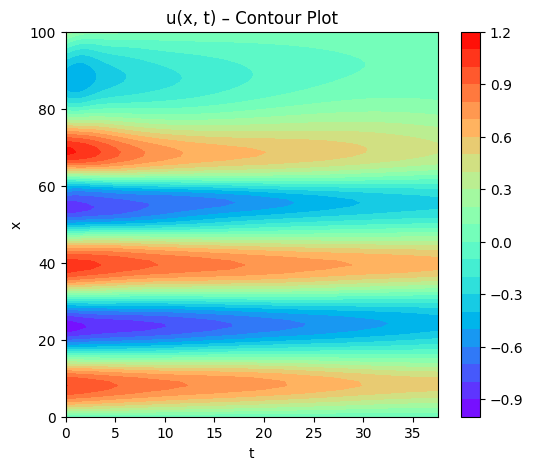

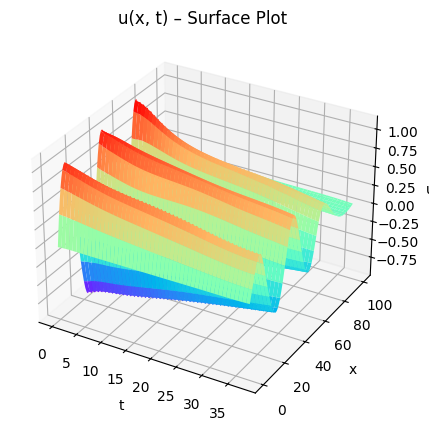

In [17]:
# 1) Determine grid dimensions
num_x, num_t = x_tensor.shape[0], t_tensor.shape[0]

# 2) Flatten X_grid and T_grid, then stack into a (num_x * num_t, 2) input tensor
X_flat = X_grid.reshape(-1, 1).to(device)
T_flat = T_grid.reshape(-1, 1).to(device)
XT     = torch.hstack([X_flat, T_flat])  # shape: (num_x*num_t, 2)

# 3) Perform forward prediction and reshape back to a (num_x, num_t) NumPy array
with torch.no_grad():
    U_flat = PINN(XT).cpu().numpy().reshape(num_x, num_t)

# 4) Convert x and t to 1D NumPy arrays for plotting
x_np = x_tensor.cpu().numpy()
t_np = t_tensor.cpu().numpy()

# 5) Plot the results using the plot3D function
plot3D(x_np, t_np, U_flat)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Assume you already have:
#   x           : 1D NumPy array of shape (num_x,)
#   t           : 1D NumPy array of shape (num_t,)
#   u_solution  : 2D NumPy array of shape (num_x, num_t)

# Example data (replace with your actual x, t, and u_solution)
num_x, num_t = 100, 200
x = np.linspace(0, 1, num_x)
t = np.linspace(0, 2, num_t)000000000000000
u_solution = np.stack([
    np.exp(-tau) * np.sin(2 * np.pi * x)
    for tau in t
], axis=1)  # shape: (num_x, num_t)

# 1) Create the figure and initial line
fig, ax = plt.subplots()
line, = ax.plot(x, u_solution[:, 0], color='C0')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(u_solution.min(), u_solution.max())
ax.set_xlabel('x')
ax.set_ylabel('u(x, t)')
title = ax.set_title('t = 0.00')

# 2) Update function for each frame
def update(frame):
    # Extract the solution at current time index
    y = u_solution[:, frame]
    # Update line data
    line.set_ydata(y)
    # Update the title to show current time
    title.set_text(f't = {t[frame]:.2f}')
    return line, title

# 3) Construct the animation
ani = FuncAnimation(
    fig,
    update,
    frames=num_t,
    interval=50,   # delay between frames in milliseconds
    blit=True
)

# 4a) Display animation in Jupyter notebook
plt.close(fig)  # prevent static display of the initial plot
HTML(ani.to_jshtml())

# —— Or to save as a GIF (requires Pillow) —— 
# writer = PillowWriter(fps=20)
# ani.save("heat_equation.gif", writer=writer)

# —— Or to save as an MP4 (requires ffmpeg) —— 
# ani.save("heat_equation.mp4", fps=20, dpi=200)


[04/22/25 22:15:00] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       animation.py:1060